<a href="https://colab.research.google.com/github/olkaand/uczenie_maszynowe/blob/use_case2/use_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TREŚĆ ZADANIA**

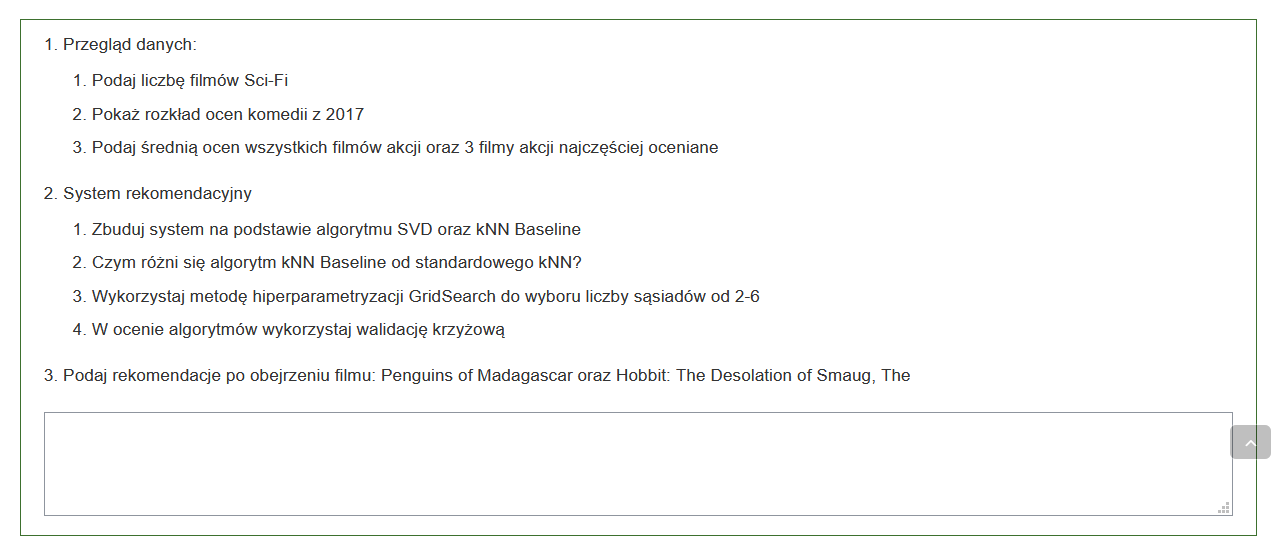

## Biblioteki i zaczytanie danych

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

!pip install surprise
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162990 sha256=e31d3dded93ae7d00f7176794b53fd7637e4ae1310f3d3d16640b9c7bb96d261
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
ratings= pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
movies= pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## 1. Przegląd danych

### 1.1 Podaj liczbę filmów sci-fi

In [5]:
movies_g = movies.assign(genres=movies['genres'].str.split('|')).explode('genres')

In [6]:
movies_g.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children
0,1,Toy Story (1995),Comedy
0,1,Toy Story (1995),Fantasy


In [7]:
unique_genres = movies_g['genres'].unique()

In [8]:
print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'War' 'Musical'
 'Documentary' 'IMAX' 'Western' 'Film-Noir' '(no genres listed)']


In [9]:
genre_counts = movies_g['genres'].value_counts()
num_scifi_movies = genre_counts.get('Sci-Fi', 0)
print("Liczba filmów w gatunku Sci-Fi:", num_scifi_movies)

Liczba filmów w gatunku Sci-Fi: 980


### 1.2 Pokaż rozkład ocen komedii z 2017 roku

In [10]:
merged_data = pd.merge(ratings, movies, on='movieId')

In [11]:
merged_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [12]:
genres = merged_data['genres'].str.get_dummies('|')

merged_data = pd.concat([merged_data, genres], axis=1)
merged_data.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
merged_data['year'] = merged_data['title'].str.extract(r'\((\d{4})\)')

In [14]:
merged_data.head()

,userId,movieId,rating,timestamp,title,genres,(no genres listed),Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995


In [15]:
comedy_2017 = merged_data[(merged_data['genres'].str.contains('Comedy')) & (merged_data['year'] == '2017')]

In [16]:
comedy_2017 = comedy_2017[['title', 'year', 'movieId', 'rating', 'Comedy']]
comedy_2017

,title,year,movieId,rating,Comedy
57556,Kingsman: The Golden Circle (2017),2017,176101,3.5,1
57557,Kingsman: The Golden Circle (2017),2017,176101,1.0,1
57558,Kingsman: The Golden Circle (2017),2017,176101,4.0,1
57559,Kingsman: The Golden Circle (2017),2017,176101,3.5,1
57560,Kingsman: The Golden Circle (2017),2017,176101,3.0,1
...,...,...,...,...,...
98379,The Meyerowitz Stories (2017),2017,173205,4.0,1
98380,War Machine (2017),2017,173209,4.0,1
99574,Daddy's Home 2 (2017),2017,180231,4.0,1
99847,Jim Gaffigan: Cinco (2017),2017,168174,3.0,1


In [17]:
ratings_distribution = comedy_2017['rating'].value_counts().sort_index()
print(ratings_distribution)

rating
0.5     2
1.0     2
1.5     5
2.0     5
2.5     6
3.0    12
3.5    17
4.0    24
4.5    10
5.0     5
Name: count, dtype: int64


<ipython-input-18-e0544b6a75ad>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(comedy_2017['rating'], bins=bins, kde=True, palette ="viridis")


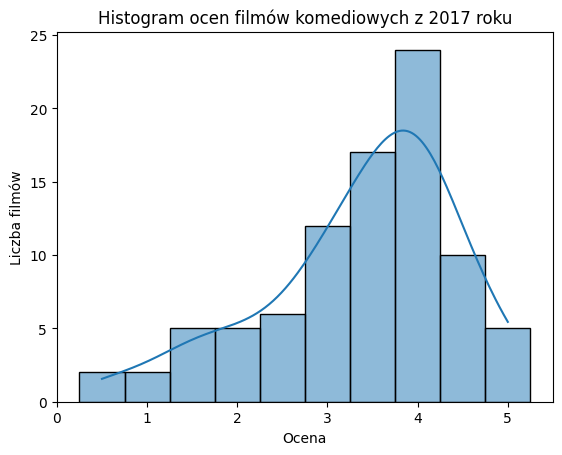

In [18]:
bins = np.arange(0.25, 5.75, 0.5)  # Tworzenie listy od 0.25 do 5.75 z krokiem 0.5

sns.histplot(comedy_2017['rating'], bins=bins, kde=True, palette ="viridis")
plt.title('Histogram ocen filmów komediowych z 2017 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba filmów')
plt.show()

<ipython-input-19-7ba0843c63c7>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(comedy_2017, x = 'rating', palette='viridis')


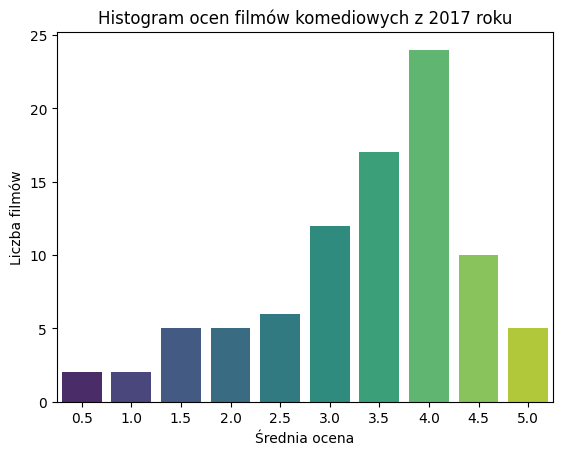

In [19]:
sns.countplot(comedy_2017, x = 'rating', palette='viridis')
plt.title('Histogram ocen filmów komediowych z 2017 roku')
plt.xlabel('Średnia ocena')
plt.ylabel('Liczba filmów')
plt.show()

In [20]:
sredni_rating = ratings['rating'].mean()
print("Ogólny średni rating dla komedii z 2017 roku:", round(sredni_rating,3))

Ogólny średni rating dla komedii z 2017 roku: 3.502


### 1.3 Podaj średnią ocenę wszystkich filmów akcji i podaj 3 filmy akcji, które były najczęściej oceniane

In [21]:
action_movie = merged_data[(merged_data['genres'].str.contains('Action'))]

In [22]:
action_movie.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres',
       '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'year'],
      dtype='object')

In [23]:
action_movie = action_movie[['title', 'userId', 'year', 'movieId', 'rating', 'Action']]
action_movie

,title,userId,year,movieId,rating,Action
267,Heat (1995),1,1995,6,4.0,1
268,Heat (1995),6,1995,6,4.0,1
269,Heat (1995),11,1995,6,5.0,1
270,Heat (1995),18,1995,6,4.0,1
271,Heat (1995),23,1995,6,4.0,1
...,...,...,...,...,...,...
100826,Return of the One-Armed Swordsman (1969),610,1969,147662,3.0,1
100830,Gen-X Cops (1999),610,1999,158721,3.5,1
100831,Bloodmoon (1997),610,1997,160341,2.5,1
100832,Sympathy for the Underdog (1971),610,1971,160527,4.5,1


In [24]:
sredni_rating_na_film = action_movie.groupby('movieId')['rating'].mean()
print("Średni rating na film akcji:", round(sredni_rating_na_film,2))

Średni rating na film akcji: movieId
6         3.95
9         3.12
10        3.50
15        3.00
20        2.50
          ... 
189547    1.00
191005    4.50
193565    3.50
193581    4.00
193587    3.50
Name: rating, Length: 1828, dtype: float64


In [55]:
sredni_rating = action_movie['rating'].mean()
print("Ogólny średni rating dla filmów akcji:", round(sredni_rating,2))

Ogólny średni rating dla filmów akcji: 3.45


In [26]:
title_counts = action_movie['title'].value_counts()

In [27]:
title_counts

title
Matrix, The (1999)                                 278
Star Wars: Episode IV - A New Hope (1977)          251
Jurassic Park (1993)                               238
Braveheart (1995)                                  237
Terminator 2: Judgment Day (1991)                  224
                                                  ... 
Wonder Woman (2009)                                  1
Highlander: The Search for Vengeance (2007)          1
Batman: Mystery of the Batwoman (2003)               1
LEGO Batman: The Movie - DC Heroes Unite (2013)      1
Hazard (2005)                                        1
Name: count, Length: 1827, dtype: int64

In [28]:
top_3_titles = title_counts.head(3)
top_3_titles

title
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Name: count, dtype: int64

## 2. System rekomendacyjny

### 2.1 Zbuduj system na podstawie algorytmu SVD oraz kNN Baseline

#### Przegląd i przygotowanie potrzebnych rzeczy

Połączenie id z tytułem

In [29]:
movie_titles= dict(zip(merged_data["movieId"], movies["title"]))
movie_titles[3] #nie obsługuje head

'Three Colors: Red (Trois couleurs: Rouge) (1994)'

Bayesian Avg

In [30]:
movie_stats = merged_data.groupby('movieId')[['rating']].agg(['count','mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [31]:
C =movie_stats["count"].mean()
m =movie_stats["mean"].mean()

In [32]:
def bayesian_avg(ratings):
  bayesian_avg=(C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ["movieId", "bayesian_avg"]

movie_stats=movie_stats.merge(bayesian_avg_ratings,on='movieId')
movie_stats.describe()

,movieId,count,mean,bayesian_avg
count,9724.000000,9724.000000,9724.000000,9724.000000
mean,42245.024373,10.369807,3.262448,3.285871
std,52191.137320,22.401005,0.869874,0.227598
min,1.000000,1.000000,0.500000,2.190377
25%,3245.500000,1.000000,2.800000,3.151413
50%,7300.000000,3.000000,3.416667,3.283341
75%,76739.250000,9.000000,3.911765,3.390547
max,193609.000000,329.000000,5.000000,4.392070


Macierz rzadka

In [33]:
def create_sparse(df):
  M = df['userId'].nunique()
  N = df['movieId'].nunique()

  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]

  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse(ratings)

In [34]:
n_total = X.shape[0] * X.shape[1]
n_ratings = X.nnz  # scipy.sparse.csr_matrix.nnzno of storedvalues, including explicit0
sparsity = n_ratings / n_total
sparsity_p = round(sparsity * 100, 2)
print(f"Matrix sparsity: {sparsity_p}%")
n_ratings_per_user = X.getnnz(axis=1)
#ile % jest uzupełnionych w macierzy rzadkiej, jednak jest za duże na macierz rzadką, musiałoby być <0,5%

Matrix sparsity: 1.7%


Szukanie ID filmu po tytule

In [35]:
def get_movie_ids_by_title(title_partial, movies = movies):

    # Use the str.contains method to find rows where the title contains the partial title (case insensitive)
    matching_movies = movies[movies['title'].str.contains(title_partial, case=False)]

    # Return the matching_movies DataFrame
    return matching_movies

In [36]:
get_movie_ids_by_title("Toy Story", movies)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
7355,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


In [37]:
get_movie_ids_by_title("Penguins of Madagascar", movies)

,movieId,title,genres
8599,117851,Penguins of Madagascar (2014),Adventure|Animation|Children|Comedy


In [38]:
get_movie_ids_by_title("Hobbit: The Desolation of Smaug, The", movies)

,movieId,title,genres
8296,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX


Liczba ocen wystawionych przez danego użytkownika

In [39]:

n_rated_movies_per_user = ratings.groupby(by='userId')['rating'].count().sort_values(ascending=False)

n_rated_movies_per_user.head()

userId
414    2698
599    2478
474    2108
448    1864
274    1346
Name: rating, dtype: int64

Filmy z jedną oceną

In [40]:
movie_ratings_counts = ratings['movieId'].value_counts()

# Zliczanie filmów z 1
movies_with_one_rating = (movie_ratings_counts == 1).sum()

print(f"Liczba filmów z 1 oceną: {movies_with_one_rating}")

print(f"Filmy z jedną oceną stanowią {((movies_with_one_rating/len(merged_data['movieId']))*100).round(2)} %")

Liczba filmów z 1 oceną: 3446
Filmy z jedną oceną stanowią 3.42 %


In [41]:
reader = Reader(rating_scale=(0.5, 5))

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

#train_set, test_set = train_test_split(data, test_size=0.25, random_state=0)
train_set = data.build_full_trainset()

#### SVD

In [42]:
#svd = SVD()
svd = SVD(random_state=0)
svd.fit(train_set)

In [43]:
def get_similar_movies_svd(movie_id, n):

    trainset = data.build_full_trainset()

    # get latent factors for the specified movie
    movie_factors = svd.qi[svd.trainset.to_inner_iid(movie_id)]

    # Compute cosine similarity between the specified movie and all other movies
    similarities = cosine_similarity([movie_factors], svd.qi)

    # Get indices of top similar movies
    similar_movie_indices = np.argsort(similarities[0])[-n-1:-1][::-1]

    # Construct a list of similar movies
    similar_movies = []
    for idx in similar_movie_indices:
        similar_movie_id = svd.trainset.to_raw_iid(idx)
        similar_movie_name = movies[movies['movieId'] == similar_movie_id]['title'].iloc[0]
        similar_movies.append(similar_movie_name)

    return similar_movies

#### kNN Baseline

In [44]:
#knn = KNNBaseline()
#cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
#knn_baseline = KNNBaseline(k=6, min_k=2, random_state=0)

sim_options = {
        "k": 6,
        "user_based": False,
    }

knn_baseline = KNNBaseline(sim_options=sim_options)
knn_baseline.fit(train_set)


# knn_baseline = KNNBaseline(k=6, random_state=0)
# knn_baseline.fit(train_set)


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [45]:
def similiar_movies_knnBaseline(movie_id, n_neighbors):
    try:
        # Konwersja raw_id na inner_id
        inner_id = knn_baseline.trainset.to_inner_iid(movie_id)

        # Znalezienie najbliższych sąsiadów filmu
        neighbors = knn_baseline.get_neighbors(inner_id, k=n_neighbors)

        # Wypisanie tytułów n najbliższych sąsiadów
        movie_info = movies[movies['movieId'] == movie_id]
        movie_title = movie_info['title'].values[0]
        movie_genres = movie_info['genres'].values[0]

        print(f'Ponieważ obejrzałeś film pod tytułem {movie_title} ({", ".join(movie_genres.split("|"))}) \n może Cie zainteresować :\n')
        for neighbor in neighbors:
            recommended_movie_info = movies[movies['movieId'] == knn_baseline.trainset.to_raw_iid(neighbor)]
            if not recommended_movie_info.empty:
                recommended_title = recommended_movie_info['title'].values[0]
                recommended_genres = recommended_movie_info['genres'].values[0]
                print(f'* {recommended_title} ({", ".join(recommended_genres.split("|"))})')
            else:
                print(f'* {recommended_title}')
    except IndexError:
        print("Nie można znaleźć sąsiadów dla tego filmu.")


### 2.2 Czym się różni kNN od kNN Baseline


Klasyfikator k najbliższych sąsiadów (kNN) i kNN Baseline to dwie różne metody, które wykorzystują koncepcję znalezienia k najbardziej podobnych obiektów w zbiorze danych do prognozowania lub rekomendowania wartości dla nowych obiektów.

Podczas przewidywania kNN oblicza odległość między nowym obiektem a wszystkimi obiektami w zestawie treningowym, a następnie wybiera k najbliższych sąsiadów. Klasyfikuje nowy obiekt na podstawie najczęstszej etykiety wśród jego k najbliższych sąsiadów.

W kNN Baseline wartość bazowa (baseline - tu średnia ocen użytkownika lub średnia ocen przedmiotu, w tym wypadku filmu) jest używana jako punkt odniesienia do porównywania wyników rekomendacji. Najczęściej kNN Baseline służy do rekomendowania produktów lub treści na podstawie podobieństwa między użytkownikami lub przedmiotami.

### 2.3 Wykorzystaj metodę hiperparametryzacji GridSearch do wyboru liczby sąsiadów od 2-6

In [46]:
param_grid = { 'k': [2, 3, 4, 5, 6] }

grid_search_KNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['mae', 'rmse'], \
                                      cv=5, n_jobs=-1)

grid_search_KNNBaseline.fit(data)

print(f'MAE Best Parameters:  {grid_search_KNNBaseline.best_params["mae"]}')
print(f'MAE Best Score:       {grid_search_KNNBaseline.best_score["mae"]}\n')

print(f'RMSE Best Parameters: {grid_search_KNNBaseline.best_params["rmse"]}')
print(f'RMSE Best Score:      {grid_search_KNNBaseline.best_score["rmse"]}\n')

MAE Best Parameters:  {'k': 6}
MAE Best Score:       0.6848360408858193

RMSE Best Parameters: {'k': 6}
RMSE Best Score:      0.8935482091364293



Hiperparametryzcja wskazała 6 sąsiadów jako najlepszą ilość.

### 2.4 W ocenie algorytmów wykorzystaj walidację krzyżową

In [47]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8799  0.8684  0.8870  0.8703  0.8649  0.8741  0.0081  
MAE (testset)     0.6759  0.6661  0.6833  0.6676  0.6670  0.6720  0.0067  
Fit time          2.10    1.71    1.53    1.53    1.56    1.69    0.22    
Test time         0.22    0.12    0.13    0.13    0.12    0.14    0.04    


{'test_rmse': array([0.87994767, 0.86844932, 0.88702517, 0.87034166, 0.86490462]),
 'test_mae': array([0.6759253 , 0.66611742, 0.68327931, 0.66755942, 0.66698088]),
 'fit_time': (2.098207473754883,
  1.7058684825897217,
  1.5304291248321533,
  1.53128981590271,
  1.5624191761016846),
 'test_time': (0.21791672706604004,
  0.12143611907958984,
  0.13422513008117676,
  0.12503743171691895,
  0.12358617782592773)}

In [48]:
cross_validate(knn_baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8713  0.8612  0.8692  0.8639  0.8656  0.8662  0.0036  
MAE (testset)     0.6678  0.6599  0.6661  0.6639  0.6628  0.6641  0.0027  
Fit time          5.84    5.58    5.09    5.55    5.82    5.58    0.27    
Test time         8.80    9.95    10.05   10.05   10.37   9.84    0.54    


{'test_rmse': array([0.87133993, 0.86117148, 0.86919667, 0.86387579, 0.8655939 ]),
 'test_mae': array([0.66778856, 0.65989433, 0.66612011, 0.66385498, 0.66283025]),
 'fit_time': (5.8393144607543945,
  5.582752227783203,
  5.085129976272583,
  5.550128698348999,
  5.819105625152588),
 'test_time': (8.796831846237183,
  9.954961776733398,
  10.052810430526733,
  10.046491384506226,
  10.365838050842285)}

KNN ma mniejsze RMSE i MAE.  Mniejsze wartości w tym przypadku oznaczają, że model lepiej dopasowuje się do danych, a w rezultacie przewidywane przez niego wartości są bliższe rzeczywistym wartościom.

# 3. Rekomendacje po obejrzeniu filmów

In [49]:
movies.loc[movies['movieId'] == 117851]

,movieId,title,genres
8599,117851,Penguins of Madagascar (2014),Adventure|Animation|Children|Comedy


In [50]:
movies.loc[movies['movieId'] == 106489]

,movieId,title,genres
8296,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX


## Dla alogytmu SVD

In [51]:
# ITEM BASED
# define which movie ID that we want to give recommendation
movie_id = 117851
# how many similar movies return
n = 5

# get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

# get recommended titles
recommended_titles = get_similar_movies_svd(movie_id, n)

print(f'Ponieważ obejrzałeś film pod tytułem {movie_title} ({", ".join(movie_genres.split("|"))}) \n może Cie zainteresować :\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')

Ponieważ obejrzałeś film pod tytułem Penguins of Madagascar (2014) (Adventure, Animation, Children, Comedy) 
 może Cie zainteresować :

* Girl with the Dragon Tattoo, The (2011) (Drama, Thriller)
* Cool World (1992) (Animation, Comedy, Fantasy)
* Damn Yankees! (1958) (Comedy, Musical)
* Life-Size (2000) (Children, Comedy, Fantasy)
* Son of God (2014) (Drama)


In [52]:
# ITEM BASED
# define which movie ID that we want to give recommendation
movie_id = 106489
# how many similar movies return
n = 5

# get movie title and genres for the selected movie
movie_info = movies[movies['movieId'] == movie_id]
movie_title = movie_info['title'].values[0]
movie_genres = movie_info['genres'].values[0]

# get recommended titles
recommended_titles = get_similar_movies_svd(movie_id, n)

print(f'Ponieważ obejrzałeś film pod tytułem {movie_title} ({", ".join(movie_genres.split("|"))}) \n może Cie zainteresować :\n')
for title in recommended_titles:
    recommended_movie_info = movies[movies['title'] == title]
    if not recommended_movie_info.empty:
        recommended_genres = recommended_movie_info['genres'].values[0]
        print(f'* {title} ({", ".join(recommended_genres.split("|"))})')
    else:
        print(f'* {title}')

Ponieważ obejrzałeś film pod tytułem Hobbit: The Desolation of Smaug, The (2013) (Adventure, Fantasy, IMAX) 
 może Cie zainteresować :

* Road to El Dorado, The (2000) (Animation, Children)
* White Fang (1991) (Adventure)
* S.W.A.T. (2003) (Action, Thriller)
* Howling II: Your Sister Is a Werewolf (1985) (Horror)
* Poker Night (2014) (Action, Crime, Thriller)


## Dla algorytmu kNN Baseline

In [53]:
similiar_movies_knnBaseline(117851, 6)

Ponieważ obejrzałeś film pod tytułem Penguins of Madagascar (2014) (Adventure, Animation, Children, Comedy) 
 może Cie zainteresować :

* Juno (2007) (Comedy, Drama, Romance)
* In Bruges (2008) (Comedy, Crime, Drama, Thriller)
* Mask, The (1994) (Action, Comedy, Crime, Fantasy)
* Shaun of the Dead (2004) (Comedy, Horror)
* Scott Pilgrim vs. the World (2010) (Action, Comedy, Fantasy, Musical, Romance)
* Happy Gilmore (1996) (Comedy)


In [54]:
similiar_movies_knnBaseline(106489,6)

Ponieważ obejrzałeś film pod tytułem Hobbit: The Desolation of Smaug, The (2013) (Adventure, Fantasy, IMAX) 
 może Cie zainteresować :

* Cocoon (1985) (Comedy, Sci-Fi)
* Flight of the Navigator (1986) (Adventure, Children, Sci-Fi)
* Revolutionary Road (2008) (Drama, Romance)
* Rob Roy (1995) (Action, Drama, Romance, War)
* Bourne Identity, The (1988) (Action, Adventure, Drama, Mystery, Thriller)
* Volcano (1997) (Action, Drama, Thriller)
